# Wordle Solver

### Data: https://www.kaggle.com/datasets/bcruise/wordle-valid-words

In [116]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

df_solutions = pd.read_csv('valid_solutions.csv')
word_list = df_solutions['word'].tolist()

In [39]:
def print_stats(data):
    df = pd.DataFrame(data, columns=['guesses_num'])
    print(df.describe()[1:])
    
def vis_stats(arrays, names, log_x=False, log_y=False, x_range=None, data_type='hist', filename='fig.png', binwidth=1):
    df_compare = pd.DataFrame(
        np.array(
            arrays,
            dtype=np.float32
        ).T,
        columns=[*names]
    )
    plot = None
    if data_type == 'hist':
        plot = sns.displot(df_compare, palette='rocket', binwidth=binwidth, kind=data_type)
    elif data_type == 'ecdf':
        plot = sns.displot(df_compare, palette='rocket', kind=data_type)
    plt.xlabel('Number of guesses')
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    if x_range:
        plt.xlim(x_range)
    plt.title('Number of guesses distribution')
    plot.savefig(filename, dpi=600)
    plt.close()

def show_stats(arrays, names, log_x=False, log_y=False, x_range=None, binwidth=1):
    _, ax = plt.subplots(1, 2, figsize=(25, 10))
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='hist.png',
        binwidth=binwidth
    )
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='ecdf.png',
        data_type='ecdf',
        binwidth=binwidth
    )
    
    ax[0].imshow(plt.imread('hist.png'))
    ax[0].axis('off')
    ax[1].imshow(plt.imread('ecdf.png'))
    ax[1].axis('off')
    
    plt.show()
    
def performance(name, array):
    guessed_words = array[array <= 6]
    coef = str(round(100 * len(guessed_words) / len(array), 2)).ljust(5, '0')
    space_gap_1 = 6 - len(str(len(guessed_words)))
    space_gap_2 = 1 if len(str(round(np.mean(array), 2))) == 4 else 0
    print(f"{name} performance:")
    print(f"{coef}% - Percentage of words guessed in 6 guesses")
    print(f"{len(guessed_words)}{' ' * space_gap_1} - Number of guessed words")
    print(f"{round(np.mean(array), 3)}{' ' * space_gap_2} - Avarage number of guesses ")
    print(f"{np.max(array)} - Max number of guesses")


## Random Algorithm

## Baseline

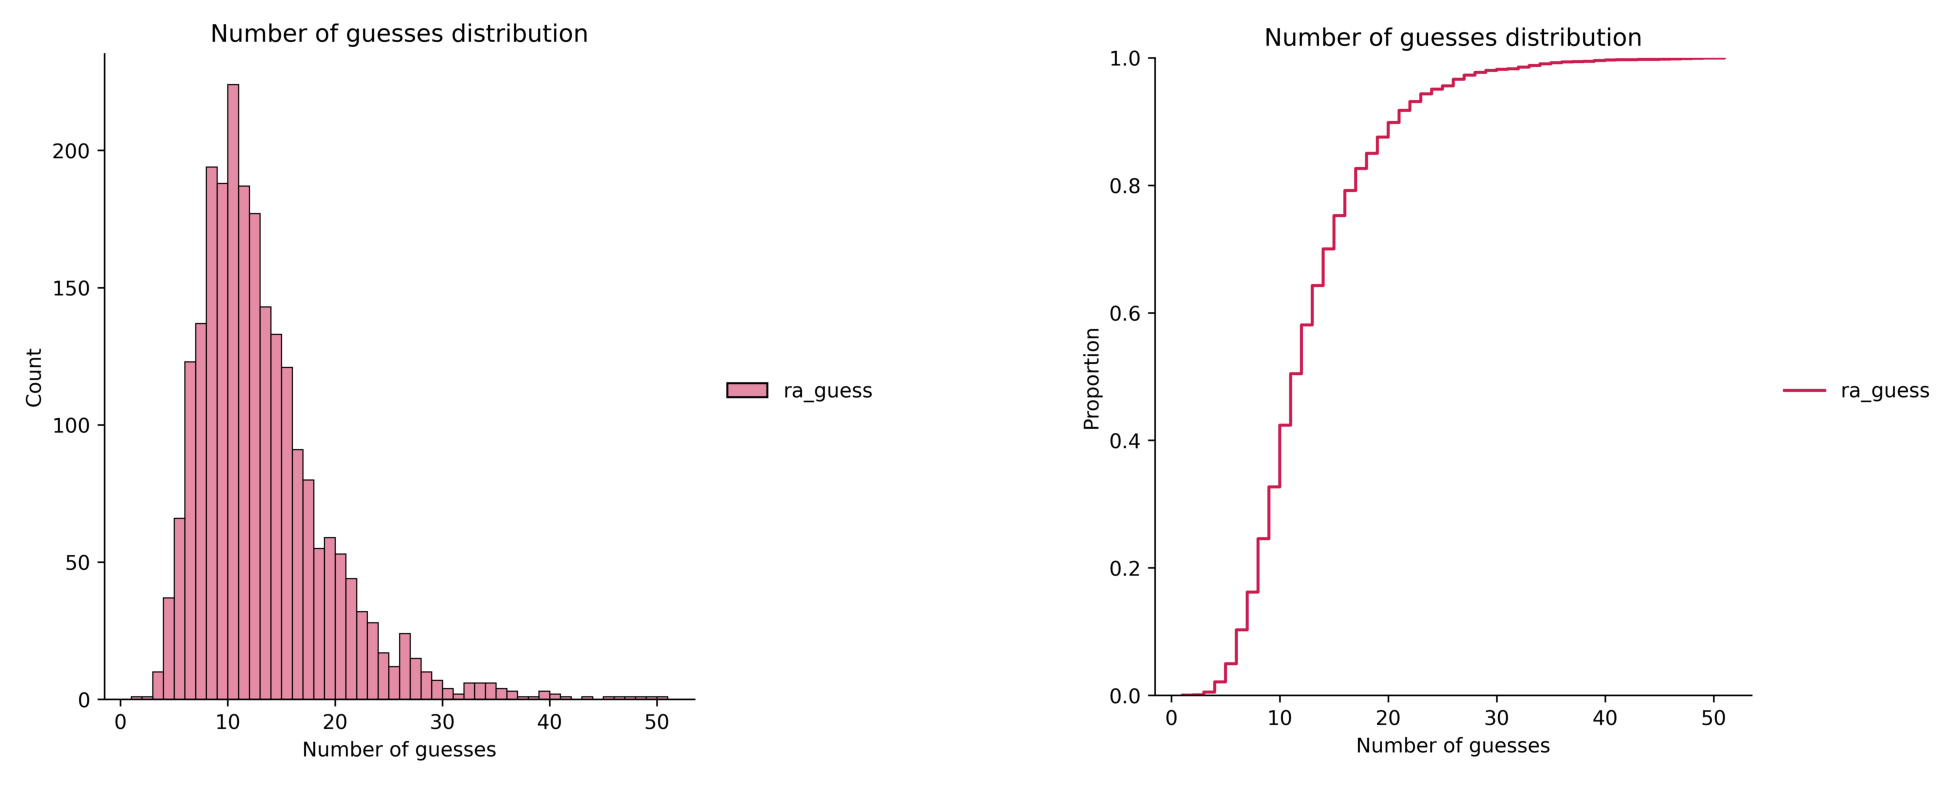

In [8]:
show_stats(arrays, names)

## Answer Recudction

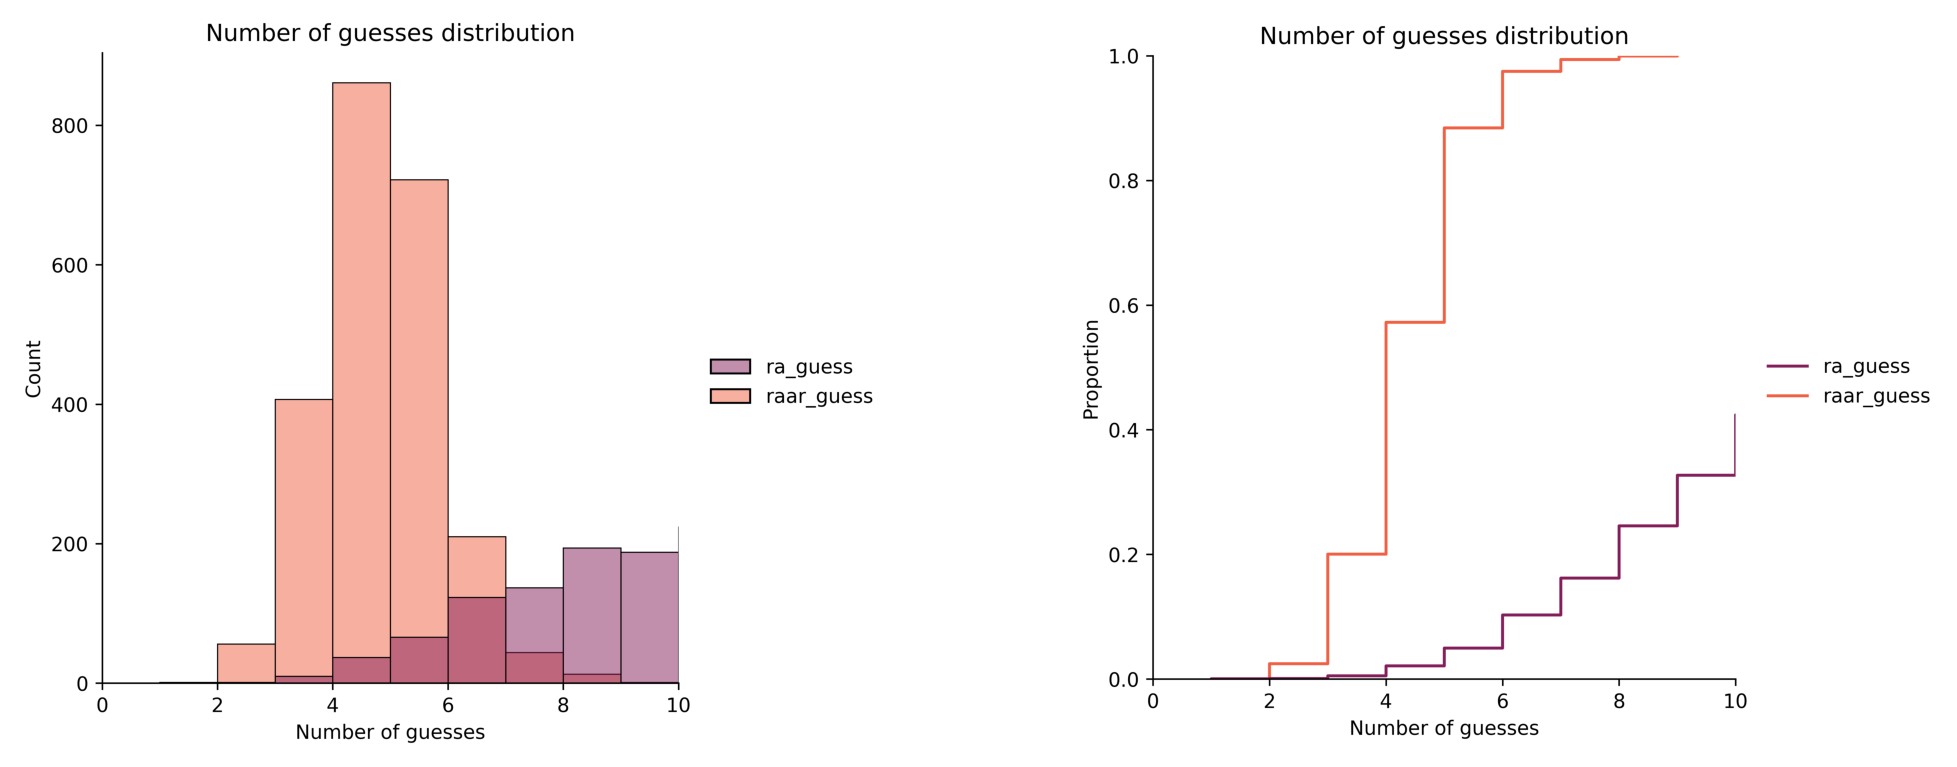

In [13]:
show_stats(arrays, names, x_range=(0, 10))

## Words Frequency

In [42]:
class RRWF(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        if len(ans) > 0:
            possible_words = [
                word for word in possible_words 
                if Algorithm.validate_ans(ans[-1], word) == ans_info[-1]
            ]
            
        apperance_tab = np.zeros([26, 5])
        for word in possible_words:
            for i in range(len(word)):
                apperance_tab[ord(word[i]) - ord('a'), i] += 1
                
        top_prediction = None
        top_score = 0
        for word in possible_words:
            score = 0
            for i in range(len(word)):
                score += apperance_tab[ord(word[i]) - ord('a'), i]
            if score > top_score:
                top_score = score
                top_prediction = word
        
        return top_prediction, possible_words

In [43]:
rrwf_stats = np.array(RRWF(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:21<00:00, 105.32guessed words/s]


In [44]:
performance('Reducing Randomness by Word Frequency', rrwf_stats)

Reducing Randomness by Word Frequency performance:
99.40% - Percentage of words guessed in 6 guesses
2301   - Number of guessed words
3.641  - Avarage number of guesses 
8 - Max number of guesses


In [45]:
arrays.append(rrwf_stats)
names.append('rrwf_guess')

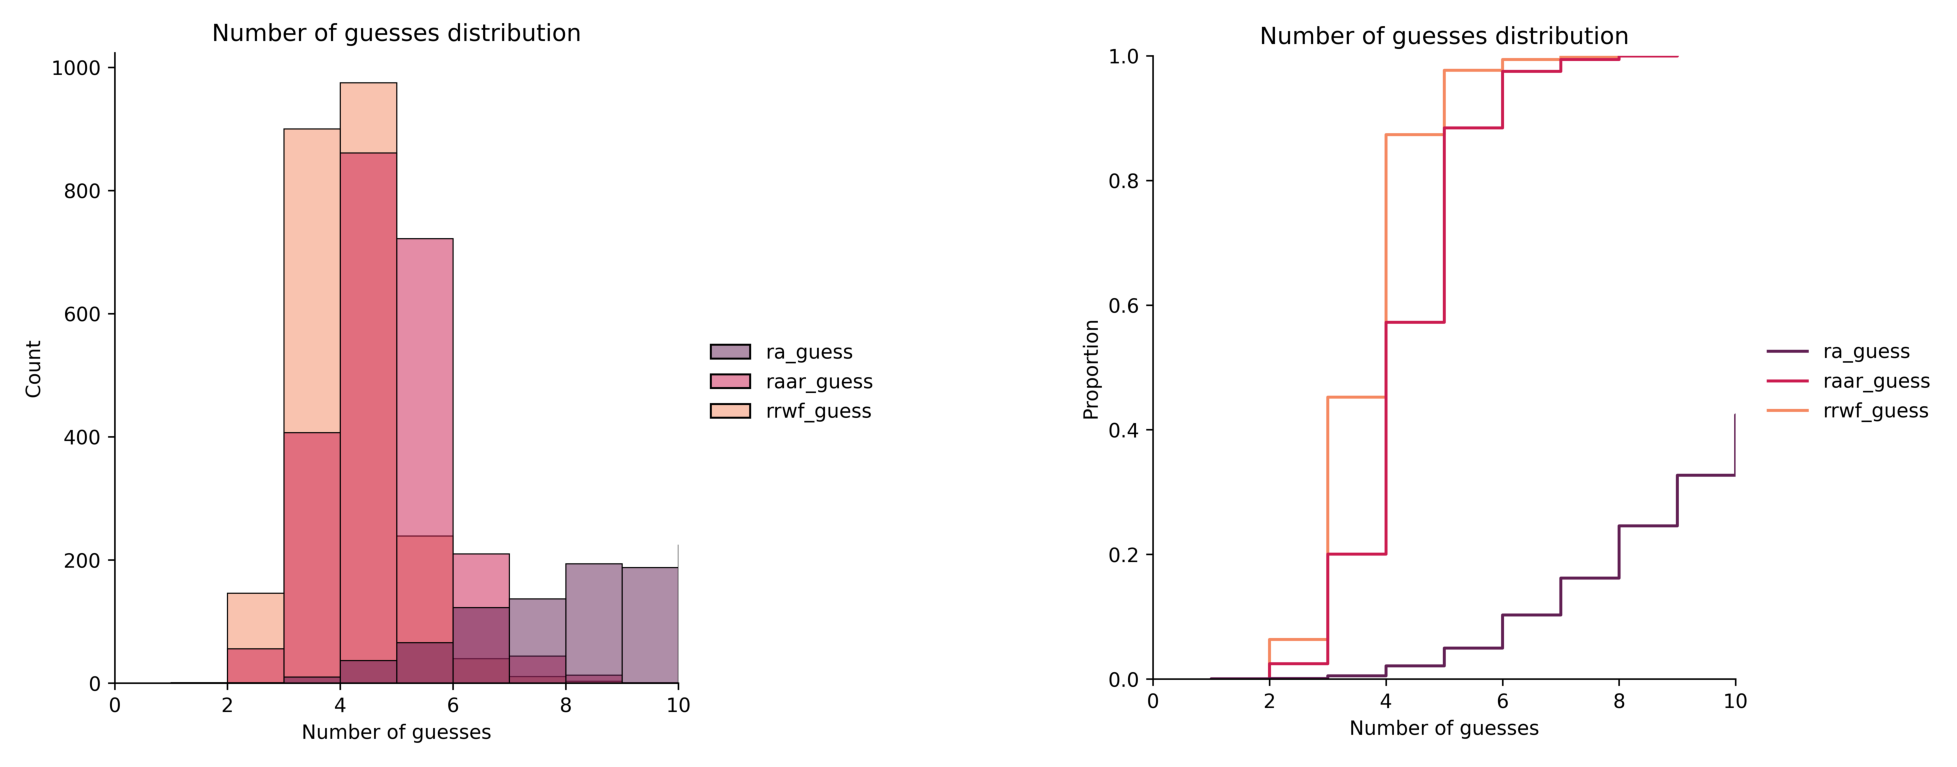

In [18]:
show_stats(arrays, names, x_range=(0, 10))